# Lab5 - Training Deep Convolutional Neural Network
- Chanya Parsurakarn ID: 59070503410
- Jarudet Wichit ID: 59070501004

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction 

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



### Your Turn! Dog or Cat Application 

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method 
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [0]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import np_utils
from keras.layers.convolutional import  MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
#!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip

In [0]:
#!unzip -qq Cat_Dog_data.zip

In [0]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,2,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs[0]
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()
    
    # Plot accuracy
    acc_plot = axs[1]
    
    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')
    
    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))
            
# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        
        
def deprocess_image(img):
    
    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1
    
    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)
    
    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')
    
    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    
    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]
    
    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)
    
    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])
    
    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)
            
            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)  

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [0]:
# Create an Iterator object. 
train_image_generator = train_datagen.flow_from_directory(directory=r"/content/Cat_Dog_data/train",
                                    target_size = (224, 224), color_mode='rgb', class_mode='binary',
                                    shuffle=True)

validate_image_generator = test_datagen.flow_from_directory(directory=r"/content/Cat_Dog_data/test",
                                    target_size = (224, 224), color_mode='rgb', class_mode='binary',
                                    shuffle=True)
train_image_generator[0][0].shape

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


(32, 224, 224, 3)

In [0]:
from keras.applications import vgg16
from keras.models import Model
import keras

In [0]:
vgg_model = vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
vgg_model.summary()











Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

In [0]:
vgg_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.layers import InputLayer

input_shape = vgg_model.output_shape[1]

custom_model = Sequential()
custom_model.add(vgg_model)
custom_model.add(Dense(512, activation='relu', input_dim=input_shape))
custom_model.add(Dropout(0.3))
custom_model.add(Flatten())
custom_model.add(layers.Dense(64, activation='relu'))
custom_model.add(layers.BatchNormalization())
custom_model.add(Dense(64,activation='relu'))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(1, activation='sigmoid'))


custom_model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 512)         262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1605696   
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense_5 (Dense)              (None, 7, 7, 512)         262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
dense_6 (Dense)              (None, 7, 7, 512)         262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
dense_7 (Dense)              (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 256)        

In [0]:
history = custom_model.fit_generator(train_image_generator, steps_per_epoch=200, epochs=100,
                              validation_data=validate_image_generator, validation_steps=50, 
                              verbose=1, max_queue_size=30, workers=70, use_multiprocessing=True)              




Epoch 1/100
200/200 [==============================] - 215s 1s/step - loss: 0.6611 - acc: 0.6020 - val_loss: 0.8613 - val_acc: 0.5306
Epoch 2/100
200/200 [==============================] - 202s 1s/step - loss: 0.6024 - acc: 0.6725 - val_loss: 0.8565 - val_acc: 0.5732
Epoch 3/100
200/200 [==============================] - 191s 956ms/step - loss: 0.5660 - acc: 0.7142 - val_loss: 0.5698 - val_acc: 0.7063
Epoch 4/100
200/200 [==============================] - 215s 1s/step - loss: 0.5493 - acc: 0.7231 - val_loss: 0.5614 - val_acc: 0.7188
Epoch 5/100
200/200 [==============================] - 203s 1s/step - loss: 0.5191 - acc: 0.7456 - val_loss: 0.5977 - val_acc: 0.7023
Epoch 6/100
200/200 [==============================] - 192s 962ms/step - loss: 0.4949 - acc: 0.7686 - val_loss: 0.6663 - val_acc: 0.6644
Epoch 7/100
200/200 [==============================] - 202s 1s/step - loss: 0.4501 - acc: 0.7941 - val_loss: 1.5994 - val_acc: 0.5305
Epoch 8/100
200/200 [==============================] -

In [0]:
custom_model.save_weights('/content/drive/My Drive/Coding AI/Lab 5/custom_model_weight')

Last train accuracy: 0.9871875
Last validation accuracy: 0.9325699745547074


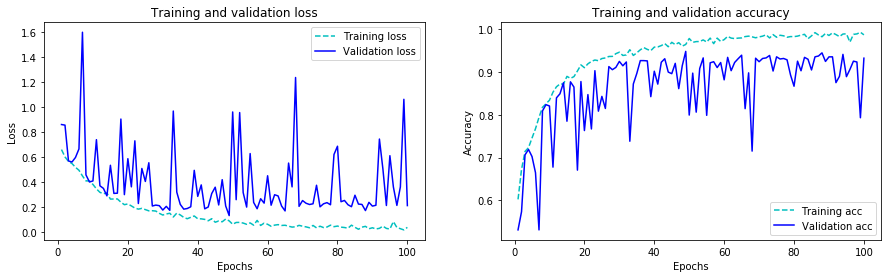

In [0]:
show_result(history)

In [0]:
result = custom_model.evaluate_generator(validate_image_generator)

In [0]:
result

[0.21153899828391148, 0.9396]

In [0]:
from keras.preprocessing import image

# load image to feed into network
img1 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Beagle.jpg',target_size=(224,224), grayscale=False)
img_tensor1 = image.img_to_array(img1)

# Preprocess data
img_tensor1 = np.expand_dims(image.img_to_array(img1),axis=0)/255.

# Feed into activation model to get an activation value
activation1 = custom_model.predict(img_tensor1)

###########################################################################################

# load image to feed into network
img2 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Golden.jpg',target_size=(224,224), grayscale=False)
img_tensor2 = image.img_to_array(img2)

# Preprocess data
img_tensor2 = np.expand_dims(image.img_to_array(img2),axis=0)/255.

# Feed into activation model to get an activation value
activation2 = custom_model.predict(img_tensor2)

###########################################################################################

# load image to feed into network
img3 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Princess.png',target_size=(224,224), grayscale=False)
img_tensor3 = image.img_to_array(img3)

# Preprocess data
img_tensor3 = np.expand_dims(image.img_to_array(img3),axis=0)/255.

# Feed into activation model to get an activation value
activation3 = custom_model.predict(img_tensor3)

###########################################################################################

# load image to feed into network
img4 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Tiger.png',target_size=(224,224), grayscale=False)
img_tensor4 = image.img_to_array(img4)

# Preprocess data
img_tensor4 = np.expand_dims(image.img_to_array(img4),axis=0)/255.

# Feed into activation model to get an activation value
activation4 = custom_model.predict(img_tensor4)

###########################################################################################

# load image to feed into network
img5 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Catty.png',target_size=(224,224), grayscale=False)
img_tensor5 = image.img_to_array(img5)

# Preprocess data
img_tensor5 = np.expand_dims(image.img_to_array(img5),axis=0)/255.

# Feed into activation model to get an activation value
activation5 = custom_model.predict(img_tensor5)

###########################################################################################

# load image to feed into network
img6 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Jarjo.png',target_size=(224,224), grayscale=False)
img_tensor6 = image.img_to_array(img6)

# Preprocess data
img_tensor6 = np.expand_dims(image.img_to_array(img6),axis=0)/255.

# Feed into activation model to get an activation value
activation6 = custom_model.predict(img_tensor6)

###########################################################################################

# load image to feed into network
img7 = image.load_img('/content/drive/My Drive/Coding AI/Lab 5/Orange_cat.jpg',target_size=(224,224), grayscale=False)
img_tensor7 = image.img_to_array(img7)

# Preprocess data
img_tensor7 = np.expand_dims(image.img_to_array(img7),axis=0)/255.

# Feed into activation model to get an activation value
activation7 = custom_model.predict(img_tensor7)

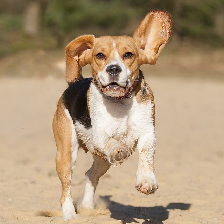

In [0]:
img1

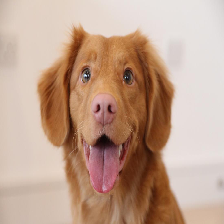

In [0]:
img2

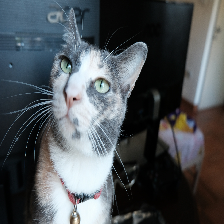

In [0]:
img3

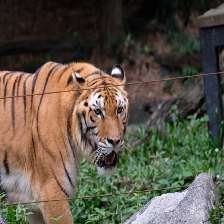

In [0]:
img4

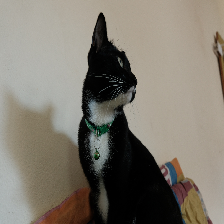

In [0]:
img5

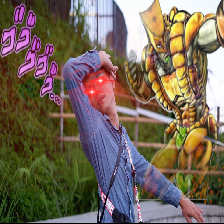

In [0]:
img6

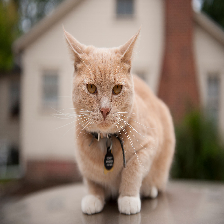

In [0]:
img7

In [0]:
activation1

array([[0.9999999]], dtype=float32)

In [0]:
activation2

array([[0.9999933]], dtype=float32)

In [0]:
activation3


array([[4.0869529e-07]], dtype=float32)

In [0]:
activation4

array([[0.00250326]], dtype=float32)

In [0]:
activation5

array([[0.22814275]], dtype=float32)

In [0]:
activation6

array([[0.99964905]], dtype=float32)

In [0]:
activation7

array([[2.2917844e-05]], dtype=float32)